In [1]:
%load_ext autoreload
%autoreload 2

import os
import h5py
import time

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.33"

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import orbax_utils
import optax
import orbax.checkpoint as ocp
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

from numpyro import distributions as dist

import torch.utils.data as data

from tqdm import tqdm
from functools import partial

from getdist import MCSamples, plots
import tarp

from jaxili.model import ConditionalMAF, NDE_Compressor
from jaxili.train import TrainerModule
from jaxili.compressor import CNN2DCompressor
from jaxili.loss import loss_nll_npe, loss_nll_nle, loss_mmd_npe, mmd_summary_space, maximum_mean_discrepancy
from jaxili.utils import create_data_loader
%matplotlib inline


2024-09-05 15:26:06.236946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#jax.config.update('jax_platform_name', 'cpu')
jax.devices()

[cuda(id=0)]

In [3]:
plt.rcParams.update({
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 25,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["times"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# Model Mispecification in cosmology

The goal of this notebook is to assess the ability of MMD to detect model misspecification using weak lensing statistics.

### Creating the dataset

Let's first create a dataset obtained from the cosmogrid simulations.

In [4]:
#Configuration for the noise augmentation
sigma_e = 0.26
galaxy_density = 10/4
field_size = size = 10
field_npix = xsize = 80
nside = 512
reso = size * 60 / xsize
nbins = 1
dim = 6

In [5]:
#Get the fiducial cosmology
master_key = jax.random.PRNGKey(0) #Create a random seed

filename = "/home/sacha/Documents/cosmogrid/CosmoGridV1_metainfo.h5"
f = h5py.File(filename, 'r') #Recover informations on the cosmogrid simulations
dataset_grid = f["parameters"]["fiducial"]
cosmo_parameters = jnp.array(
    [
        dataset_grid["Om"],
        dataset_grid["s8"],
        dataset_grid["w0"],
        dataset_grid["H0"] / 100,
        dataset_grid["ns"],
        dataset_grid["Ob"]
    ]
).T
truth = list(cosmo_parameters[0])
path = "/home/sacha/Documents/cosmogrid/projected_probes_maps_baryonified512.h5"
m_data = h5py.File(path, "r")
m_data = np.array(m_data["kg"][f"stage3_lensing{4}"]) + np.array(m_data["ia"][f'stage3_lensing{4}'])
proj = hp.projector.GnomonicProj(rot=[0, 0, 0], xsize=xsize, ysize=xsize, reso=reso)
m_data = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))
path = "/home/sacha/Documents/cosmogrid/projected_probes_maps_baryonified512.h5"
m_data_mms = h5py.File(path, "r")
m_data_mms = np.array(m_data_mms["kg"][f"stage3_lensing{4}"]) #Turn off intrinsic alignment
m_data_mms = proj.projmap(m_data_mms, vec2pix_func=partial(hp.vec2pix, nside))

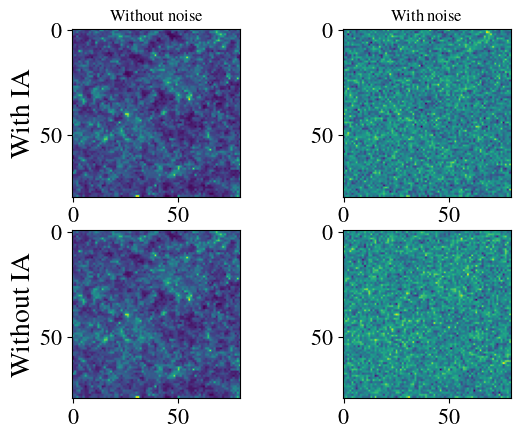

In [6]:
plt.figure()

plt.subplot(221)
plt.title("Without noise")
plt.imshow(m_data.squeeze())
plt.ylabel("With IA")

key, master_key = jax.random.split(master_key)
m_data_noise = dist.Independent(
    dist.Normal(
        m_data,
        sigma_e / jnp.sqrt(galaxy_density * (field_size*60/field_npix)**2),
    ),
    2,
).sample(key, (1,))

plt.subplot(222)
plt.title("With noise")
plt.imshow(m_data_noise.squeeze())

plt.subplot(223)

plt.imshow(m_data_mms.squeeze())
plt.ylabel("Without IA")

key, master_key = jax.random.split(master_key)
m_data_mms_noise = dist.Independent(
    dist.Normal(
        m_data_mms,
        sigma_e / jnp.sqrt(galaxy_density * (field_size*60/field_npix)**2),
    ),
    2,
).sample(key, (1,))

plt.subplot(224)

plt.imshow(m_data_mms_noise.squeeze())

plt.show()

In [7]:
params_name = [
    r"$\Omega_m$",
    r"$\sigma_8$",
    r"$w_0$",
    r"$h_0$",
    r"$n_s$",
    r"$\Omega_b$",
]

cosmo_labels_gd = [
    r'\Omega_m', r'\sigma_8', r'w_0', r'h', r'n_s', r'\Omega_b'
]

In [8]:
#Data loading and augmentation
def augmentation_noise(
    example, sigma_e=0.31, galaxy_density=7, field_size=10, field_npix=80
):
    x = example["map_nbody_w_baryon_ia"]
    """ x += tf.random.normal(
        shape=(field_npix, field_npix),
        stddev=sigma_e * jnp.sqrt(galaxy_density * (field_size*60/field_npix)**2)
    ) """
    return {"maps": x, "theta": example["theta"]}

def augmentation_flip(example):
    x = tf.expand_dims(example["maps"], 0)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return {"maps": x, "theta": example["theta"]}

def augmentation(example):
    return augmentation_flip(
        augmentation_noise(
            example,
            sigma_e=sigma_e,
            galaxy_density=galaxy_density,
            field_size=field_size,
            field_npix=field_npix
        ))

In [9]:
dim_params = dim
comp_dim = dim #Sufficient statistics
#dim + e.g. 16 for overcomplete statistics

comp_hparams = {
    'output_size': comp_dim,
    'activation': jax.nn.leaky_relu
}

nf_hparams = {
    'n_in': dim_params,
    'n_cond': comp_dim,
    'n_layers': 5,
    'layers': [128, 128],
    'activation': jax.nn.relu,
    'use_reverse': True,
    'seed': 42
}

#Create the model
nf_cnn_compressor = NDE_Compressor(
    CNN2DCompressor,
    ConditionalMAF,
    comp_hparams,
    nf_hparams
)

key, master_key = jax.random.split(master_key)
params_nf_cnn = nf_cnn_compressor.init(key, cosmo_parameters[0], m_data_noise)

print(
    f'Number of parameters: {sum(x.size for x in jax.tree_util.tree_leaves(params_nf_cnn))}'
)

Number of parameters: 154082


In [33]:
#Load and augment the dataset

# Train set
ds_tr = tfds.load("CosmogridGridDataset/grid_maps", split="train")

ds_tr = ds_tr.shuffle(800)
ds_tr = ds_tr.map(augmentation)
ds_tr = ds_tr.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds_tr))

# Test set
ds_te = tfds.load("CosmogridGridDataset/grid_maps", split="test")

ds_te = ds_te.shuffle(200)
ds_te = ds_te.map(augmentation)
ds_test = iter(tfds.as_numpy(ds_te))

In [16]:
for el in ds_train:
    print('coucou')

In [32]:
next(ds_train)['maps'].shape

(1, 80, 80)

In [34]:
print("Train set size: ", len(ds_tr))
print("Test set size: ", len(ds_te))

Train set size:  157325
Test set size:  70000


In [35]:
class CosmogridDataset(data.Dataset):
    def __init__(self, ds):
        self.observation = np.array([x["maps"] for x in ds])
        #self.thetas = np.array([x["theta"] for x in ds])
        del ds

    def __len__(self):
        return len(self.observation)

    def __getitem__(self, idx):
        return self.observation[idx]

In [36]:
train_set = CosmogridDataset(ds_train)
test_set = CosmogridDataset(ds_test)

batch_size = 128
train_loader, test_loader = create_data_loader(
    train_set, test_set,
    train=[True, False],
    batch_size=batch_size
)

: 

In [13]:
print(np.array([x["maps"] for x in ds_train]).shape)

2024-09-05 15:22:09.767621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
type(next(ds_train)["maps"])

numpy.ndarray

In [65]:
np.expand_dims(el["maps"], 0).shape

(1, 1, 80, 80)

In [30]:
train_set[10]

IndexError: index 10 is out of bounds for axis 0 with size 0

In [14]:
next(iter(train_loader))

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_6243/2662580783.py", line 11, in __getitem__
    return self.thetas[idx], self.observation[idx]
IndexError: index 73826 is out of bounds for axis 0 with size 0


In [44]:
CHECKPOINT_PATH = "~/Documents/Research Projects/SBI_model_misspecification/cosmo/"

loss_fn = loss_mmd_npe

model_hparams = {
    'compressor': CNN2DCompressor,
    'nf': ConditionalMAF,
    'comp_hparams': comp_hparams,
    'nf_hparams': nf_hparams
}

optimizer_hparams = {
    'lr': 5e-4,
    'optimizer_name': 'adam'
}

logger_params = {
    'base_log_dir': CHECKPOINT_PATH
}

check_val_every_epoch = 1

debug = False

In [48]:
next(iter(train_loader))

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_7405/2717171970.py", line 12, in __getitem__
    return self.thetas[idx], self.observation[idx]
IndexError: index 46510 is out of bounds for axis 0 with size 0


In [47]:
trainer = TrainerModule(
    model_class=NDE_Compressor,
    model_hparams=model_hparams,
    optimizer_hparams=optimizer_hparams,
    loss_fn=loss_fn,
    exmp_input=next(iter(train_loader)),
    logger_params=logger_params,
    debug=debug,
    check_val_every_epoch=check_val_every_epoch
)

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_7405/2717171970.py", line 12, in __getitem__
    return self.thetas[idx], self.observation[idx]
IndexError: index 73826 is out of bounds for axis 0 with size 0


In [12]:
#Configuration for the training
checkpoint_path = "/home/sacha/Documents/Research project/SBI_model_misspecification/cosmogrid/checkpoints"
epochs = 10
learning_rate = 5e-4
warmup = 0.1

lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=1e-4,
    peak_value=learning_rate,
    end_value = 0.01*learning_rate,
    warmup_steps = warmup,
    decay_steps = int(epochs * ds_tr.cardinality().numpy() * 128 * 0.9)
)
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=lr_scheduler)
)

opt_state = optimizer.init(params_nf_cnn)

In [13]:
compress = lambda params, x : nf_cnn_compressor.apply(params, x, method="compress")
nf = lambda params, theta, z : nf_cnn_compressor.apply(params, theta, z, method="log_prob_from_compressed")
loss_fn = lambda params, x, theta : loss_mmd_npe(compress, nf, params, (theta, x))

#Training loop
params_nf_cnn, opt_state, loss, train_loss_tracker, val_loss_tracker = training_loop(
    params_nf_cnn,
    opt_state, 
    epochs=epochs,
    train_set=ds_tr,
    test_set=ds_te,
    loss_fn=loss_fn,
    generative_model=nf_cnn_compressor,
    optimizer=optimizer,
    master_key=master_key,
    checkpoint_path=None
)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]2024-09-04 16:38:50.769511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-04 16:40:07.137255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epochs (train/val/best): -5.00e+00/-7.59e+00/-7.59e+00:  10%|█         | 1/10 [01:59<17:53, 119.27s/it]2024-09-04 16:40:31.548795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-04 16:41:41.064917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epochs (train/val/best): -8.53e+00/-5.01e+00/-7.59e+00:  20%|██        | 2/10 [03:33<13:55, 104.38s/it]2024-09-04 16:42:05.263515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE:

Training done. Time take: 965.80s
Best loss: -9.43e+00 at epoch 9


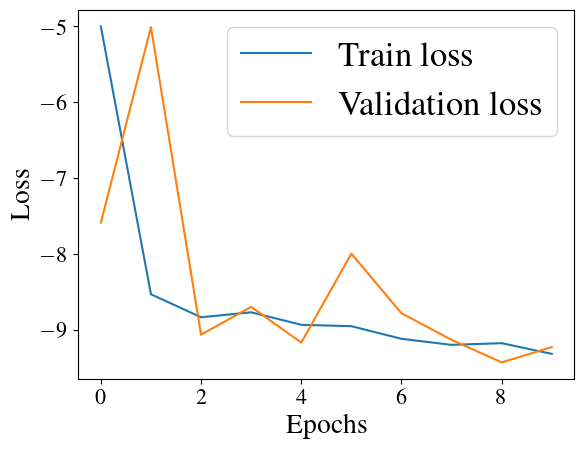

In [14]:
plt.figure()

plt.plot(train_loss_tracker, label="Train loss")
plt.plot(val_loss_tracker, label="Validation loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
ds_test = iter(tfds.as_numpy(ds_te))
batch = next(ds_test)
x, theta = batch["maps"], batch["theta"]

In [34]:
z_val = compress(params_nf_cnn, x)
key, master_key = jax.random.split(master_key)
mmd = mmd_summary_space(z_val, key)
log_prob = nf(params_nf_cnn, theta, z_val)

print(f"MMD: {mmd}")
print(f"Negative Log_Likelihood: {-jnp.mean(log_prob)}")
print(f"Loss: {-jnp.mean(log_prob) + mmd}")

MMD: 0.4444313049316406
Negative Log_Likelihood: -9.66695785522461
Loss: -9.222526550292969


In [36]:
from loss import gaussian_kernel_matrix

gauss = jax.random.normal(key, (z_val.shape[0]*10, 6))

m, n = z_val.shape[0], gauss.shape[0]
loss = (1.0/(m * (m-1)))*jnp.sum(gaussian_kernel_matrix(z_val, z_val))
loss += (1.0/(n * (n-1)))*jnp.sum(gaussian_kernel_matrix(gauss, gauss))
loss -= 2.0/(m * n)*jnp.sum(gaussian_kernel_matrix(z_val, gauss))
print(loss)

0.5343323


In [44]:
gaussian_kernel_matrix(z_val, gauss)

Array([[ 8.989221 , 10.844786 , 10.994179 , ..., 10.524424 , 10.508448 ,
        10.443487 ],
       [ 8.87639  , 12.002539 , 11.87319  , ..., 10.456465 , 10.4370575,
        10.448917 ],
       [ 8.7199545, 10.940887 , 10.629429 , ...,  9.178185 ,  9.159027 ,
         9.244926 ],
       ...,
       [ 7.1613235, 10.124258 , 10.224569 , ...,  9.635861 ,  9.612654 ,
         9.203842 ],
       [ 8.143091 , 10.868521 , 11.157459 , ..., 11.012245 , 10.9913845,
        10.60267  ],
       [ 9.369373 , 10.281175 , 10.521516 , ..., 10.812657 , 10.816851 ,
        11.0238495]], dtype=float32)

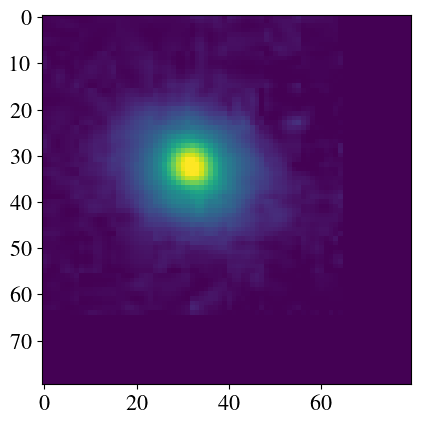

In [17]:
from PIL import Image

im = Image.open("/home/sacha/Documents/Thèse/ERC/euclid-school-2024/dataset/zoo-data/test/smooth/0001.jpg")
im = np.asarray(im)
new_im = np.zeros((80, 80))
new_im[:im.shape[0], :im.shape[1]] = im[:, :, 0]

plt.imshow(new_im)

Removed no burn in
Removed no burn in


MMD fiducial: 7.335062026977539
MMD Misspecified: 8.179153442382812


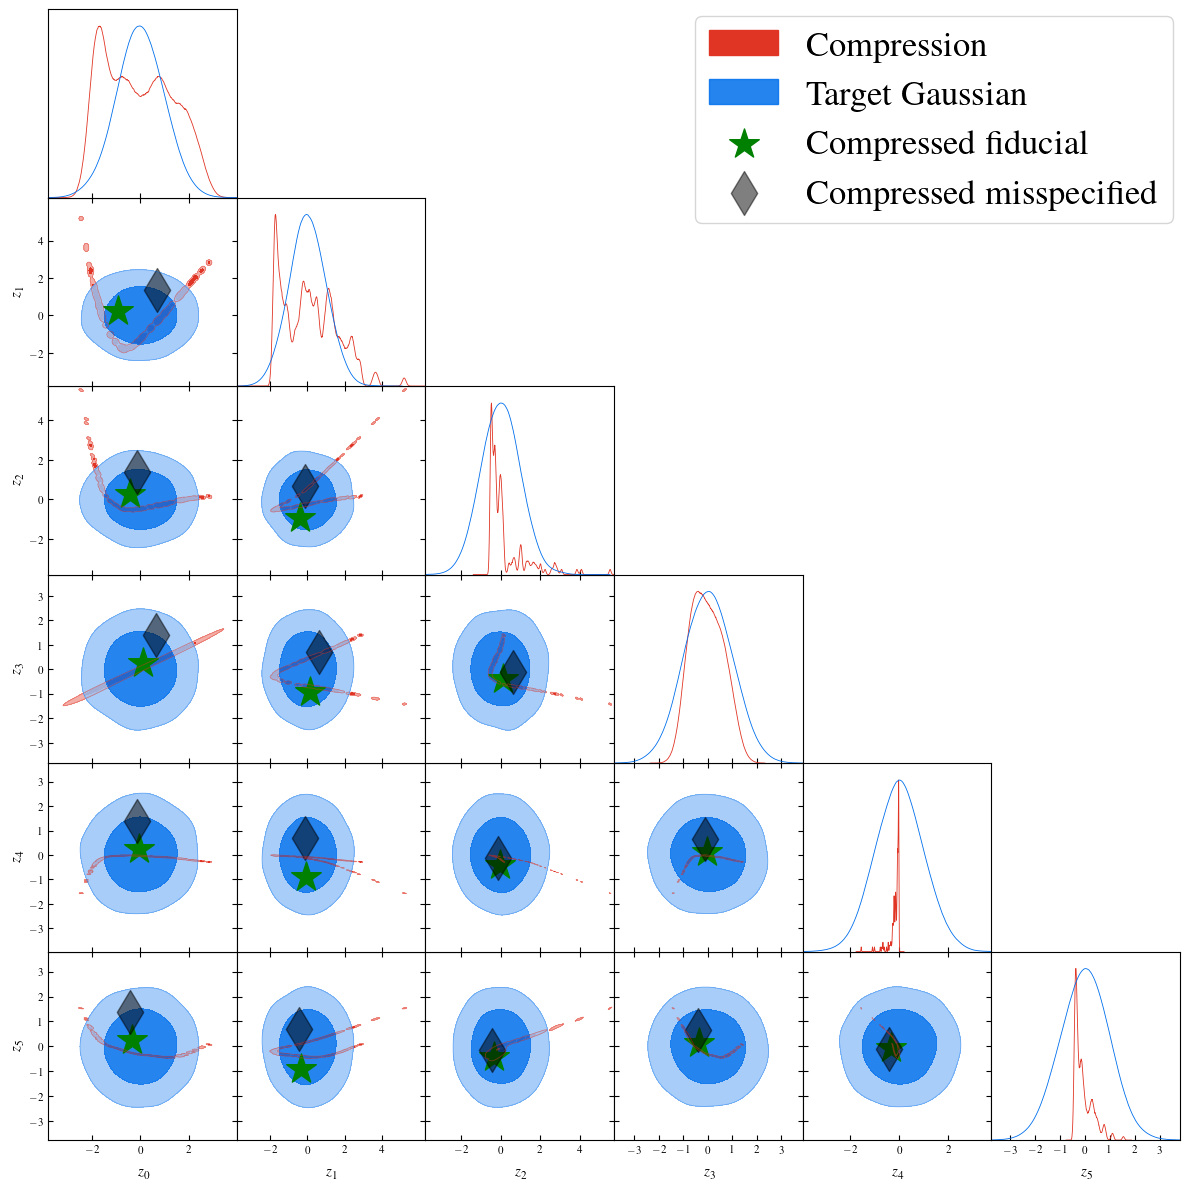

In [18]:
names = [f"z_{i}" for i in range(z_val.shape[1])]
labels = [f"z_{i}" for i in range(z_val.shape[1])]
samples_z = MCSamples(
    samples=z_val,
    names=names,
    labels=labels,
    label='Compression'
)

key, master_key = jax.random.split(master_key)
samples_gaussian = MCSamples(
    samples=jax.random.multivariate_normal(mean=jnp.zeros(comp_dim), cov=jnp.eye(comp_dim), key=key, shape=(10_000,)),
    names=names,
    labels=labels,
    label='Target Gaussian'
)

g = plots.get_subplot_plotter()
g.triangle_plot([samples_z, samples_gaussian], names, filled=True)

z_obs = compress(params_nf_cnn, m_data_noise)

mmd = maximum_mean_discrepancy(z_obs.reshape((1, -1)), z_val)

print(f"MMD fiducial: {mmd}")

z_mms = compress(params_nf_cnn, m_data_mms_noise)#new_im.reshape((1, 80, 80)))

mmd = maximum_mean_discrepancy(z_mms.reshape((1, -1)), z_val)

print(f"MMD Misspecified: {mmd}")

for i in range(comp_dim):
    for j in range(comp_dim):
        if i > j:
            ax = g.get_axes(ax=(i, j))
            obs_handle = ax.scatter([z_obs[i]], [z_obs[j]], s=500, color='g', marker='*', label='Compressed fiducial')
            mms_handle = ax.scatter([z_mms[i]], [z_mms[j]], s=500, color='k', marker='d', label='Compressed misspecified', alpha=0.5)
handles = g.fig.legends[0].legend_handles
handles.append(obs_handle)
handles.append(mms_handle)
labels = ['Compression', 'Target Gaussian', 'Compressed fiducial', 'Compressed misspecified']
g.fig.legends[0].remove()
g.fig.legend(handles, labels, loc='upper right')


plt.show()

### Assessing the performance of the normalizing flow

In [51]:
#Coverage plot using TARP
batch = next(ds_test)
x, theta = batch["maps"], batch["theta"]
nsamples = 10_000
samples = np.empty(shape=(0, nsamples, dim))
params = np.empty(shape=(0, dim))
for i in range(3):
    batch = next(ds_test)
    x, theta = batch["maps"], batch["theta"]
    for data_x, data_theta in tqdm(zip(x, theta)):
        params = np.vstack([params, data_theta])
        key, master_key = jax.random.split(master_key)
        new_samples = nf_cnn_compressor.apply(params_nf_cnn, key, data_x, n_samples=nsamples, method="sample")
        new_samples = np.array(new_samples).reshape((1, -1, dim))
        samples = np.vstack([samples, new_samples])
samples = samples.reshape((nsamples, -1, dim))

128it [01:15,  1.69it/s]
128it [01:19,  1.60it/s]
128it [01:26,  1.49it/s]


In [52]:
tarp_ = tarp.get_tarp_coverage(samples, params, bootstrap=True)

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


In [53]:
tarp_low, tarp_mid_low, tarp_mid, tarp_mid_up, tarp_up = np.percentile(tarp_[0], q=[2.5, 16, 50, 84, 98.5], axis=0)

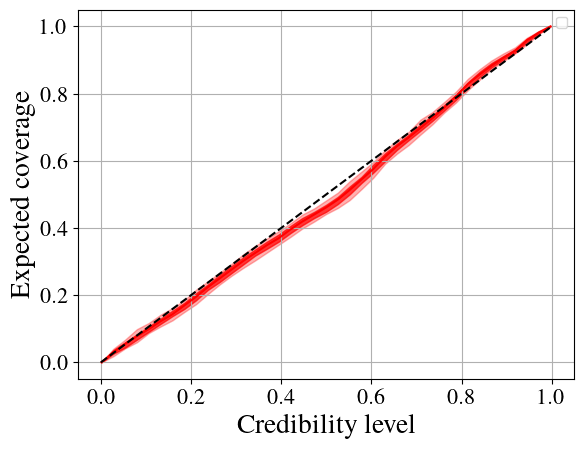

In [55]:
plt.figure()

plt.plot(tarp_[1], tarp_mid, color='red')
plt.fill_between(tarp_[1], tarp_mid_low, tarp_mid_up, color='red', alpha=0.7)
plt.fill_between(tarp_[1], tarp_low, tarp_up, color='red', alpha=0.3)
alpha = np.linspace(0, 1, num=100)
plt.plot(alpha, alpha, ls='--', c='k')
plt.legend()
plt.xlabel("Credibility level")
plt.ylabel("Expected coverage")
plt.grid()

plt.show()


In [75]:
#Coverage plot for Omega_m and sigma_8
batch = next(ds_test)
x, theta = batch["maps"], batch["theta"]

Omega_m_err = []
Omega_m = []
sigma_8 = []
sigma_8_err = []

for data_x, data_theta in tqdm(zip(x, theta)):
    key, master_key = jax.random.split(master_key)
    new_samples = nf_cnn_compressor.apply(params_nf_cnn, key, data_x, n_samples=nsamples, method="sample")
    estim_param = np.percentile(new_samples, q=50, axis=0)
    estim_param_err = np.std(new_samples, axis=0)
    Omega_m.append(estim_param[0])
    Omega_m_err.append(estim_param_err[0])
    sigma_8.append(estim_param[1])
    sigma_8_err.append(estim_param_err[1])

128it [01:27,  1.46it/s]


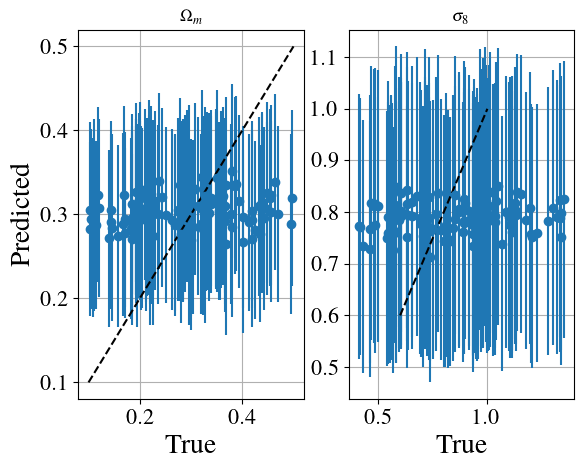

In [76]:
plt.figure()

plt.subplot(121)

plt.title(r"$\Omega_m$")

x = np.linspace(0.1, 0.5, num=100)
plt.errorbar(theta[:, 0], Omega_m, yerr=Omega_m_err, fmt='o')
plt.plot(x, x, ls='--', c='k')

plt.xlabel("True")
plt.ylabel("Predicted")

plt.grid()

plt.subplot(122)

plt.title(r"$\sigma_8$")

x = np.linspace(0.6, 1.0, num=100)
plt.errorbar(theta[:, 1], sigma_8, yerr=sigma_8_err, fmt='o')
plt.plot(x, x, ls='--', c='k')
plt.xlabel("True")

plt.grid()
plt.show()


### Posterior check on the fiducial simulation

In [63]:
key, master_key = jax.random.split(master_key)
samples_fiducial = nf_cnn_compressor.apply(params_nf_cnn, key, m_data_noise, n_samples=10_000, method="sample")

Removed no burn in


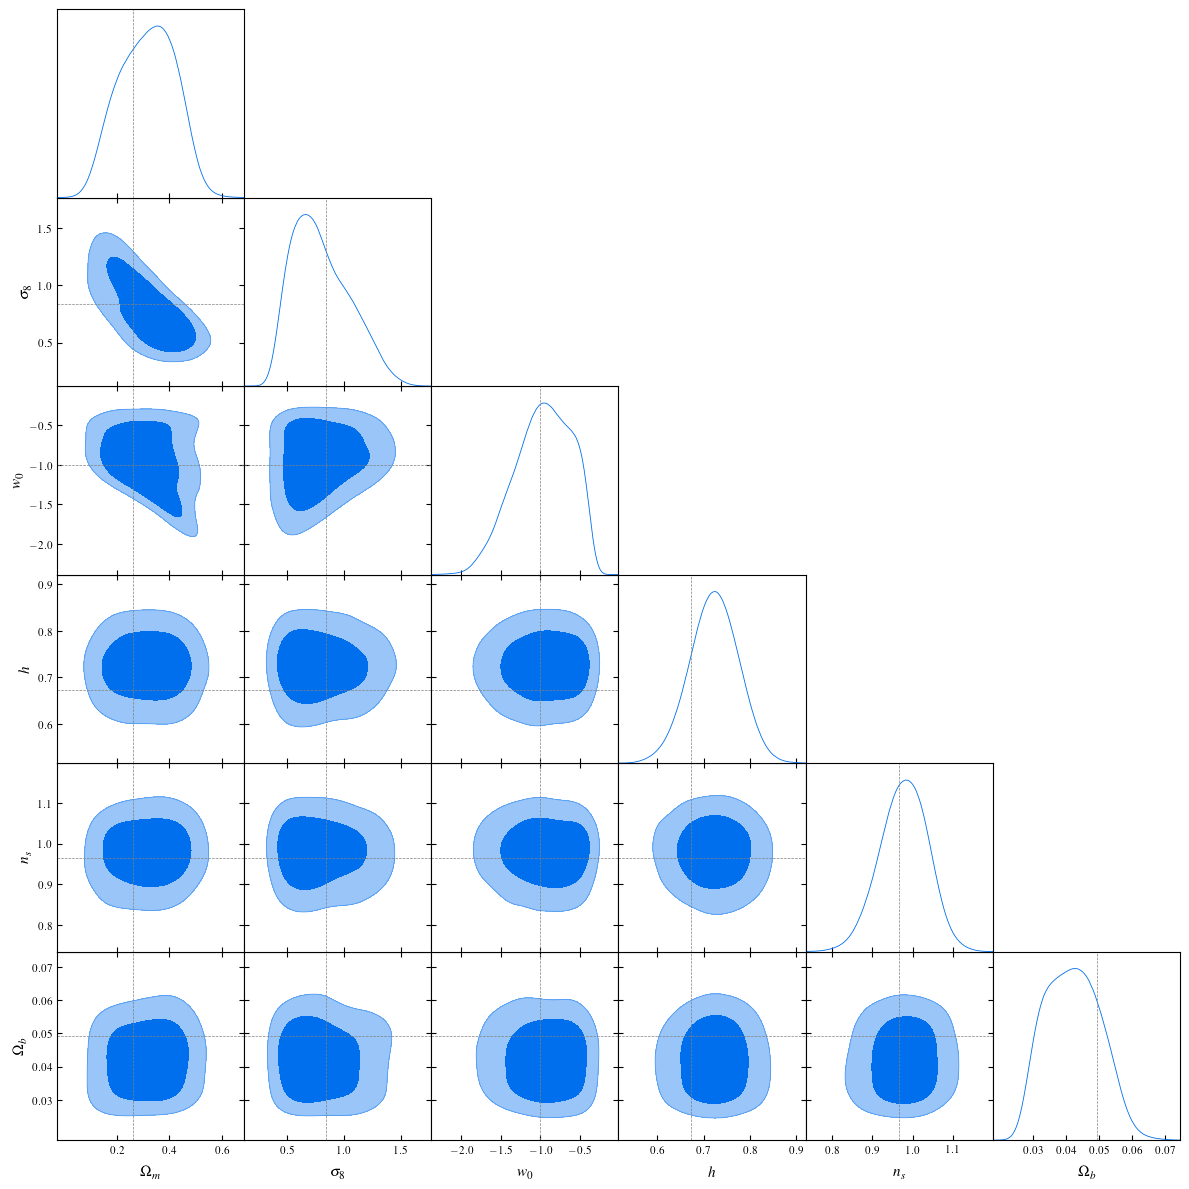

In [71]:
samples_fid_gd = MCSamples(
    samples = samples_fiducial,
    names = cosmo_labels_gd,
    labels = cosmo_labels_gd
)

g = plots.get_subplot_plotter()
g.triangle_plot(samples_fid_gd, cosmo_labels_gd, filled=True,
markers={
                    label: val for label, val in zip(cosmo_labels_gd, truth)   
               })

plt.show()

### Comparison to what would be obtained with the package sbi